# Препроцессинг
В этом ноутбуке мы будем строить pipeline препроцессинга данных на примере одного гидропоста

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

from rdm_helpers import get_meteo, helper_save, split_df_by, na_heat_map, interpolate_df
import rdm_helpers

plt.style.use('ggplot')

Так как мы будем обучать отдельные модели для каждого гидропоста для удобства разделим подготовленные файлы по station_id

In [6]:
old_data_path = 'datasets/'
data_path = './data/hydro/'
df_names = ['daily', 'disch_d', 'ice']

In [7]:
# for df_name in df_names:
#     df = pd.read_pickle(old_data_path + "processed_data/"+ df_name + ".pkl")
#     for grp, df in split_df_by(df, 'station_id'):
#         df.to_csv(data_path + '0' + str(grp) + '_' + df_name + '.csv', index=False)

Рассмотрим станцию расположенную на зейском водохранилище

In [8]:
station_id = 6275#5024#5012

In [9]:
hydro_df = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')
# ice_df = pd.read_csv(data_path + '/0' + str(station_id) + '_ice.csv', engine='python')
meteo_df, _ = get_meteo(station_id, 'datasets/')

### Данные с гидропостов

In [10]:
hydro_df

,stage_avg,stage_min,stage_max,temp,water_code,station_id
date,,,,,,
1984-01-01,368.0,332.0,404.0,1.4,2.0,6275
1984-01-02,411.0,388.0,434.0,1.4,2.0,6275
1984-01-03,435.0,423.0,446.0,1.4,2.0,6275
1984-01-04,420.0,404.0,435.0,1.4,2.0,6275
1984-01-05,427.0,410.0,443.0,1.4,2.0,6275
...,...,...,...,...,...,...
2017-12-27,358.0,349.0,367.0,1.8,29.3,6275
2017-12-28,353.0,351.0,355.0,1.8,29.3,6275
2017-12-29,357.0,348.0,365.0,1.8,30.0,6275


In [11]:
hydro_df.index = pd.to_datetime(hydro_df.index)

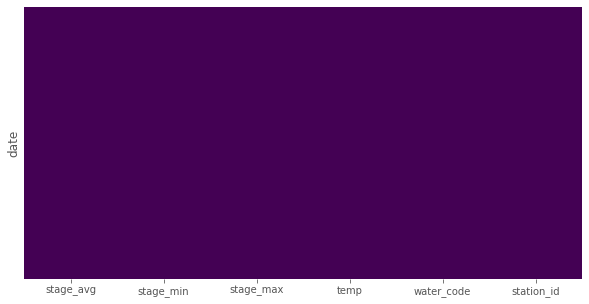

In [12]:
na_heat_map(hydro_df, figsize = (10, 5))

Интерполируем температуру воды

In [13]:
hydro_df = interpolate_df(hydro_df, cols = ['temp'])

In [14]:
hydro_df['stage_delta'] = (hydro_df['stage_max'] - hydro_df['stage_min'])

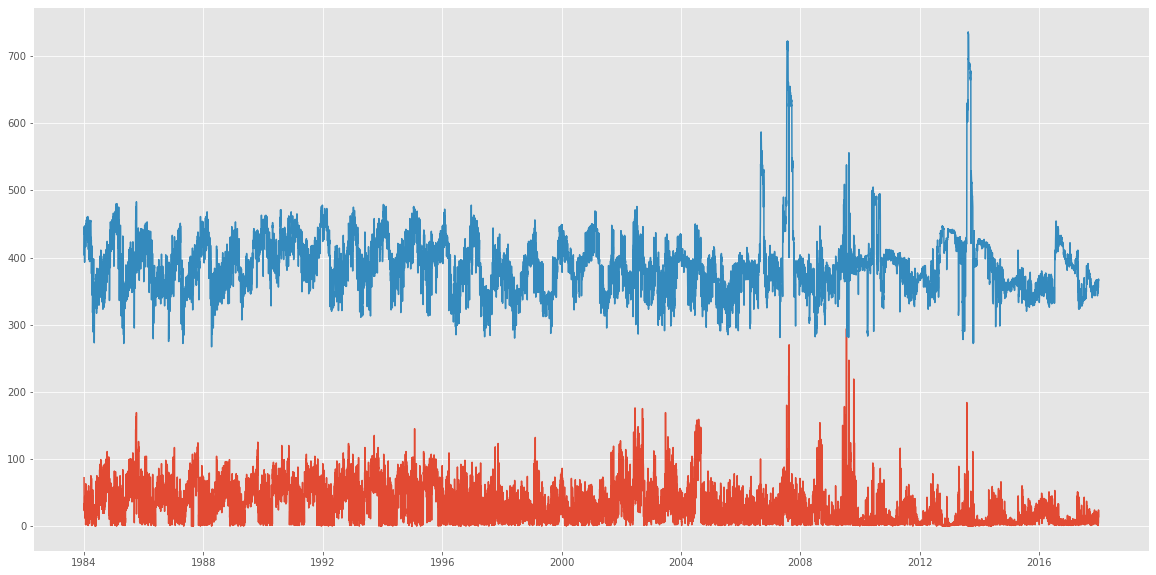

In [15]:
from rdm_helpers import plot_series
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'])

In [16]:
hydro_df[hydro_df['water_code'] == 12]

,stage_avg,stage_min,stage_max,temp,water_code,station_id,stage_delta
date,,,,,,,


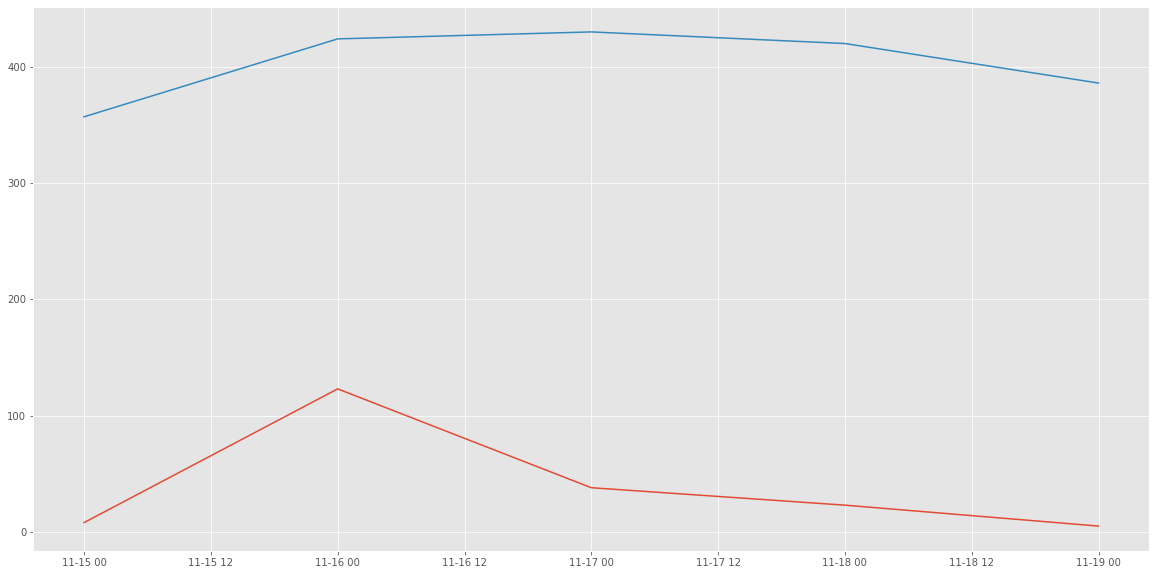

In [17]:
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'], start_date = '1997-11-15', end_date = '1997-11-19')

Очевидно, что заторы влияют на уровень воды, однако это может происходить крайне редко

In [18]:
hydro_df['congestion_up'] = hydro_df['water_code'] == 11
hydro_df['congestion_down'] = hydro_df['water_code'] == 12

In [19]:
hydro_df = hydro_df.drop(['water_code', 'station_id', 'stage_min', 'stage_avg'], axis = 1)

<AxesSubplot:xlabel='date'>

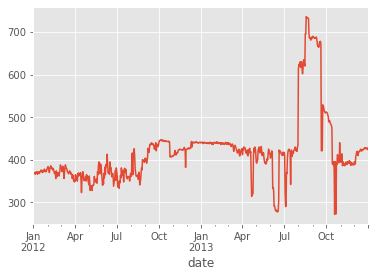

In [20]:
hydro_df['stage_max']['2012-01-01' : '2013-12-31'].plot()

In [21]:
hydro_df['doy'] = hydro_df.index.dayofyear

In [22]:
import statsmodels.api as sm

def substract_seasonality(series, period):
    return series - sm.tsa.seasonal_decompose(series, period = period).seasonal
hydro_df['seasonality'] = sm.tsa.seasonal_decompose(hydro_df['stage_max'], period = 365).seasonal
# hydro_df['seasonality']['2013-01-01':'2014-01-01'].plot()
# hydro_df['stage_max'] = substract_seasonality(hydro_df['stage_max'], 365)

In [23]:
#hydro_df[''] = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')

## Метео

In [24]:
meteo_df

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
time,,,,,,,,,,,,,,,,,,,,
2013-04-17 21:00:00,PIKAN,5372731,94.0,0,0.0,0,0.0,0,NaN,0.0,0,NaN,NaN,5,-0.7,0,-2.4,0,96.0,0
2013-04-17 18:00:00,PIKAN,5372731,84.0,0,0.0,0,0.0,0,NaN,0.0,0,NaN,NaN,5,-0.8,0,-2.5,0,92.0,0
2013-04-17 15:00:00,PIKAN,5372731,84.0,0,0.0,0,0.0,0,NaN,0.0,0,NaN,NaN,5,-1.5,0,-2.0,0,94.0,0
2013-04-17 12:00:00,PIKAN,5372731,84.0,0,0.0,0,0.0,0,NaN,0.0,0,NaN,0.9,0,-3.4,0,-1.0,0,98.0,0
2013-04-17 09:00:00,PIKAN,5372731,98.0,0,0.0,0,0.0,0,NaN,2.0,0,NaN,NaN,5,3.7,0,2.8,0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-31 00:00:00,PIKAN,5372731,99.0,0,140.0,0,2.0,0,NaN,4.0,0,NaN,NaN,5,20.0,0,13.9,0,54.0,0
2000-05-31 03:00:00,PIKAN,5372731,99.0,0,200.0,0,2.0,0,NaN,4.0,0,NaN,NaN,5,21.5,0,17.0,0,46.0,0
2000-05-31 06:00:00,PIKAN,5372731,99.0,0,30.0,0,2.0,0,NaN,4.0,0,NaN,NaN,5,19.5,0,15.5,0,64.0,0


In [25]:
meteo_df.index = pd.to_datetime(meteo_df.index)

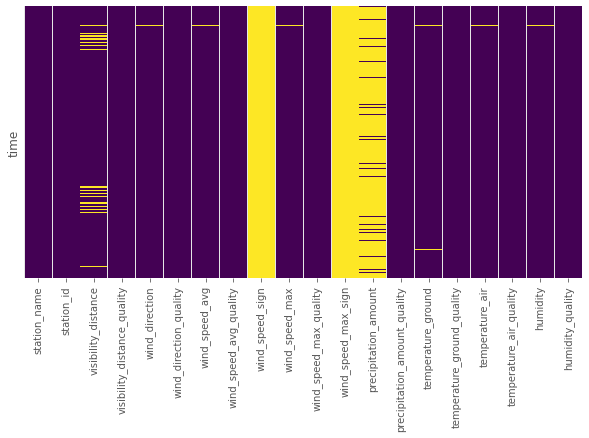

In [26]:
na_heat_map(meteo_df, figsize = (10, 5))

In [27]:
variebles = ['humidity', 'temperature_air', 'temperature_ground', 'precipitation_amount', 'wind_speed_max', 'wind_direction']
for var in variebles:
    meteo_df.loc[meteo_df[var + '_quality'] > 2, var] = np.nan

<AxesSubplot:xlabel='time'>

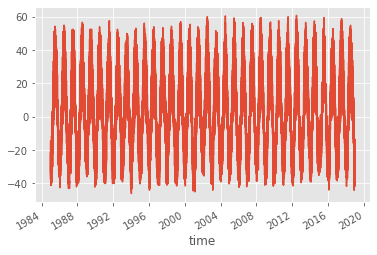

In [28]:
meteo_df['temperature_ground']['1985-01-01': '2019-01-04'].plot()

In [29]:
meteo_df['hour'] = list(map(lambda x: x.hour, meteo_df.index.time))

In [30]:
meteo_df = meteo_df.resample('D')\
.agg({
    'precipitation_amount': 'sum',
    'temperature_air': 'mean',
    'temperature_ground': 'mean',
    'humidity': 'mean'
})

In [31]:
meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
# meteo_df['precipitation_amount'] = meteo_df['precipitation_amount'].shift(1).rolling(4).sum()

In [32]:
meteo_df = interpolate_df(meteo_df, cols = ['temperature_ground', 'humidity'])

In [33]:
meteo_df.index.rename('date', inplace=True)
meteo_df

,precipitation_amount,temperature_air,temperature_ground,humidity
date,,,,
1985-01-01,0.0,-31.7500,-32.4125,NaN
1985-01-02,0.0,-27.7125,-30.9125,NaN
1985-01-03,0.0,-17.4250,-21.3625,NaN
1985-01-04,0.0,-18.1875,-21.4875,NaN
1985-01-05,0.0,-16.5000,-19.8750,NaN
...,...,...,...,...
2018-12-27,0.0,-18.7375,-22.8625,691.875
2018-12-28,0.0,-16.6000,-21.2500,696.625
2018-12-29,0.0,-17.4500,-21.8000,704.500


In [34]:
def extract_seasonality(series, period):
    return sm.tsa.seasonal_decompose(series, period = period).seasonal
# meteo_df['temperature_ground'] = substract_seasonality(meteo_df['temperature_ground'], 365)
# meteo_df['temperature_ground'].plot()

In [35]:
# up_stations = [6323, 6299, 6265, 6302, 6319]
# up_stations_df = []
# for i in up_stations:
#     up_stations_df.append(pd.read_csv(data_path + '/0' + str(i) + '_daily.csv', index_col = 'date', engine='python'))

# for (i, d) in enumerate(up_stations_df):
#     d.index = pd.to_datetime(d.index)

#     d = interpolate_df(d, cols = ['stage_max'])
#     hydro_df['prev_' + str(i)] = d['stage_max']

In [104]:
df = pd.concat([hydro_df, meteo_df.reindex(hydro_df.index)], axis = 1)
df

,stage_max,temp,stage_delta,congestion_up,congestion_down,doy,seasonality,precipitation_amount,temperature_air,temperature_ground,humidity
date,,,,,,,,,,,
1984-01-01,404.0,1.4,72.0,False,False,1,18.052790,NaN,NaN,NaN,NaN
1984-01-02,434.0,1.4,46.0,False,False,2,15.206630,NaN,NaN,NaN,NaN
1984-01-03,446.0,1.4,23.0,False,False,3,11.875704,NaN,NaN,NaN,NaN
1984-01-04,435.0,1.4,31.0,False,False,4,9.727344,NaN,NaN,NaN,NaN
1984-01-05,443.0,1.4,33.0,False,False,5,15.124521,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,367.0,1.8,18.0,False,False,361,15.124521,0.0,-20.9875,-27.1000,587.000
2017-12-28,355.0,1.8,4.0,False,False,362,17.247975,0.0,-26.8375,-29.3125,617.375
2017-12-29,365.0,1.8,17.0,False,False,363,14.793845,0.0,-17.8250,-21.9625,649.875


Baseline

In [106]:
df = TimeSeriesExtracter(['stage_delta', 'temp','precipitation_amount', 'temperature_ground', 'stage_max'],# 'humidity'], #+ ['prev_' + str(i) for i in range(4)],
                    [1,1,1,1, 1],
                    [4,4,10,8, 1]).fit_transform(df)

In [107]:
df = df['1985-01-01':]

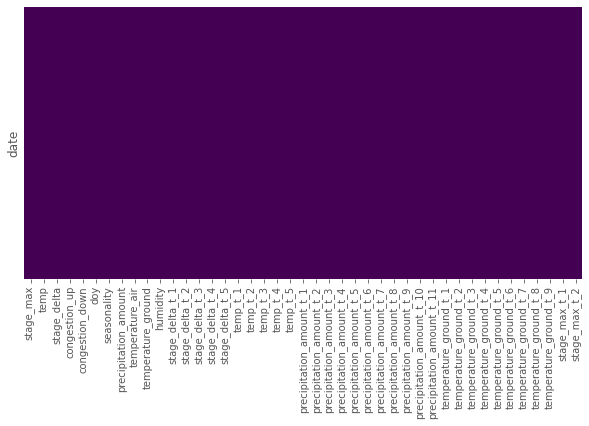

In [108]:
na_heat_map(df['1985-01-01':], figsize = (10, 5))

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12053 entries, 1985-01-01 to 2017-12-31
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stage_max                  12053 non-null  float64
 1   temp                       12053 non-null  float64
 2   stage_delta                12053 non-null  float64
 3   congestion_up              12053 non-null  bool   
 4   congestion_down            12053 non-null  bool   
 5   doy                        12053 non-null  int64  
 6   seasonality                12053 non-null  float64
 7   precipitation_amount       12053 non-null  float64
 8   temperature_air            12053 non-null  float64
 9   temperature_ground         12053 non-null  float64
 10  humidity                   12037 non-null  float64
 11  stage_delta_t_1            12053 non-null  float64
 12  stage_delta_t_2            12053 non-null  float64
 13  stage_delta_t_3            12

In [110]:
random_state = 228
label_name = 'stage_max'

In [111]:
from sklearn.model_selection import train_test_split
train_end = '2016-12-31'
test_start = '2017-01-01'
# test_end = '2017-11-11'

X = df.drop(['temp', 'stage_delta', 'precipitation_amount', 'temperature_ground', 'temperature_air', label_name], axis = 1)
Y = df[label_name]

X_train, X_test, y_train, y_test = X[:train_end], X[test_start:], Y[:train_end], Y[test_start:] #train_test_split(df.drop([label_name], axis = 1), df[label_name], train_size=0.75, random_state=random_state)

In [112]:
import lightgbm as lgb
def custom_RMSE(y_true, y_pred):
    squared_residual = 2 * (y_pred - y_true)
    grad = squared_residual
    hess = np.ones(len(y_true))
    return grad, hess

parameters = {     
#     'task': 'train',
#     'boosting_type': 'gbdt',
     'objective': 'rmse',
     'random_state': 42,
     'metric': ['l2', 'mae', 'mse'],
     'learning_rate': 0.004,
     'feature_fraction': 0.8,
     'bagging_fraction': 0.4,
#     'bagging_freq': 10,
     "n_estimators":500,
     "max_depth": 8,
     "num_leaves": 32,  
     "max_bin": 512,
     "n_jobs": 4,
     "random_state": random_state,
     "early_stopping_rounds":100,
    
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMRegressor() 

model.set_params(**parameters, metrics = ["mse", 'mae'])

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
#     random_state = random_state,
    verbose=False,
)

Found `early_stopping_rounds` in params. Will use it instead of argument


LGBMRegressor(bagging_fraction=0.4, early_stopping_rounds=100,
              feature_fraction=0.8, learning_rate=0.004, max_bin=512,
              max_depth=8, metric=['l2', 'mae', 'mse'], metrics=['mse', 'mae'],
              n_estimators=500, n_jobs=4, num_leaves=32, objective='rmse',
              random_state=228)

In [113]:
# def step_forecast(model, var_prefix, x, n, d):
#     x_ = x.copy()
#     predictions = []
#     for i in range(n):
#         prediction = model.predict(x_)
#         predictions.append(prediction)
#         if i != n - 1:
#             for k in range(2, d + 1, -1):
#                 x_[var_prefix + str(k)] = x_[var_prefix + str(k - 1)] 
#             x_[var_prefix + '10'] = prediction
#     return np.stack(predictions, axis=0)

In [114]:
# forecast = step_forecast(model, 'stage_max_t_', X_test, 10, 20)

In [118]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

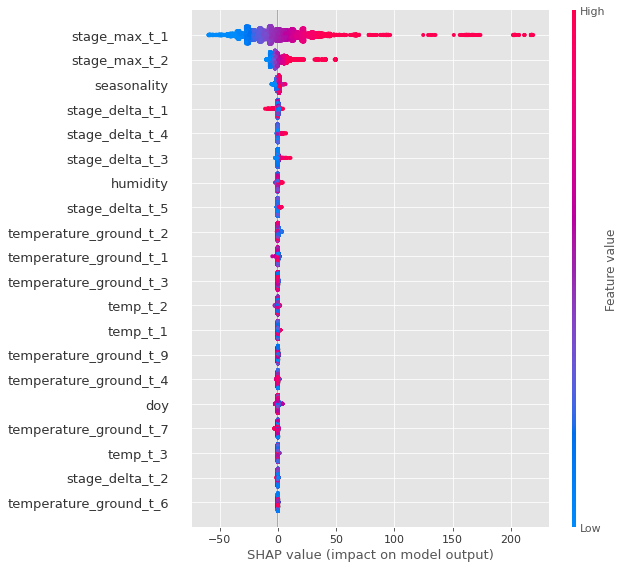

In [119]:
shap.summary_plot(shap_values, X_importance)

In [115]:
from sklearn.metrics import mean_absolute_error as mae
predict = model.predict(X_test)
true = y_test.values
mae(true, predict)

8.223017909369077

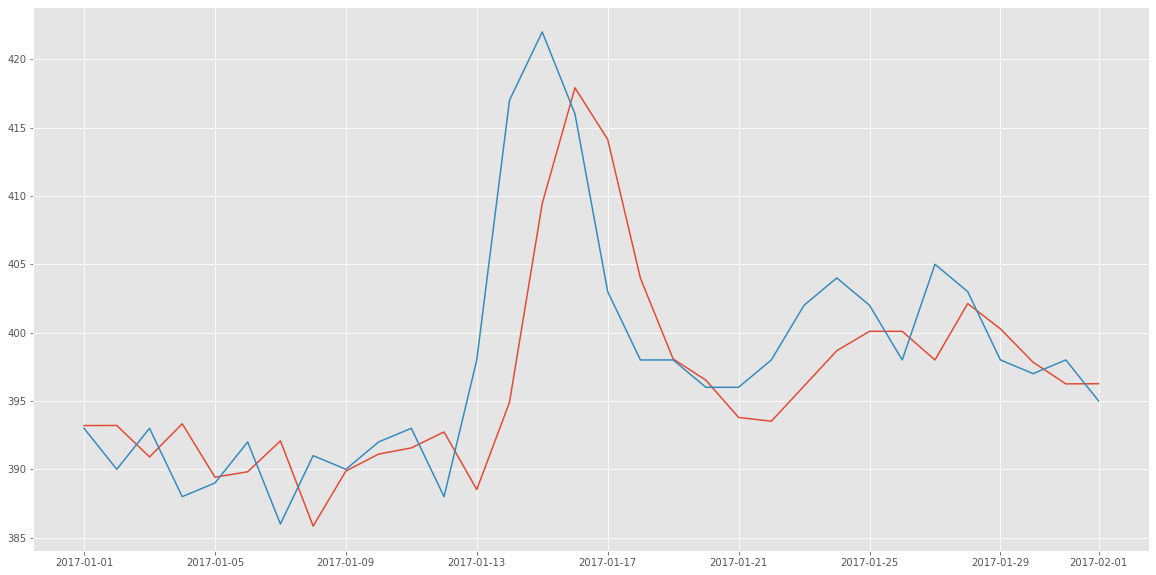

In [117]:
res = pd.DataFrame(y_test.copy())
res['predicted'] = predict
plot_series(res['2017-01-01': '2017-2-01'], cols = ['predicted', 'stage_max'])